# Práctica 2

Procesamiento de Lenguaje Natural
Facultad de Ingeniería, UNAM

González Flores Andrés

## Instrucciones

A partir del corpus proporcionado ("corpusML.txt") realizar un modelo del lenguaje neuronal con base en la arquitectura propuesta por Bengio (2003).

Síganse los siguientes pasos:

1. Limpiar los textos y aplicar stemming a las palabras.
2. Insertar símbolos de inicio y final de cadena.
3. Obtener los bigramas que aparecen en el texto (indexar numéricamente).
4. Entrenar con los bigramas la red neuronal y obtener los valores para los hiperparámetros. Tomar de 100 unidades para la primera capa oculta (capa lineal) y 300 para la segunda capa oculta (capa con tanh).
5. Obtener las matrices $A$ y $\Pi$ a partir de las salidas de la red neuornal (probabilidad Softmax).
6. Evaluar el modelo (con Entropía).
7. Calcular la proabilidad de las siguientes oraciones:
    - Nos bañamos con agua caliente
    - El animalito le olía la cabeza
    - Pascuala ordeñaba las vacas

## Desarrollo

In [1]:
# Importar módulos
import numpy as np
import re
from nltk import SnowballStemmer
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from itertools import chain

In [2]:
# Definición de constantes
np.random.seed(42)
stemmer_esp = SnowballStemmer('spanish')
CORPUS_PATH = './Data/corpusML.txt'
BOS = '<BOS>'
EOS = '<EOS>'
UNK = '<unk>'

### Paso 1

Limpiar los textos y aplicar stemming a las palabras.

In [3]:
with open(CORPUS_PATH, 'r', encoding='utf-8') as f:
    corpus = [
        list(map(lambda token: stemmer_esp.stem(token), # Mapeo cada token a su stem
            re.findall('[a-zA-zñáéíóúü]+', linea.lower()) # Devuelve una lista con todas las ocurrencias que coincidan con la regex
        ))
        for linea in f
    ]
    for docs in corpus[:5]:
        print(docs) # Muestro 5 ejemplos

['comenc', 'a', 'trabaj', 'y', 'me', 'peg', 'me', 'maltrat', 'con', 'chicot']
['mis', 'patron', 'me', 'peg', 'porqu', 'no', 'me', 'quer', 'apur', 'porqu', 'era', 'floj']
['por', 'eso', 'me', 'hab', 'peg']
['cuand', 'me', 'peg', 'ya', 'entonc', 'me', 'quit']
['pues', 'entonc', 'no', 'quis', 'trabaj']


Divido el corpus en entrenamiento y evaluación

In [4]:
train_corpus, eval_corpus = train_test_split(corpus, test_size=0.3)

print(f'\nTamaño del corpus de entrenamiento: {len(train_corpus)}')
print('Ejemplos:')
for docs in train_corpus[:5]:
        print(docs) # Muestro 5 ejemplos

print(f'\nTamaño del corpus de evaluación: {len(eval_corpus)}')
print('Ejemplos:')
for docs in eval_corpus[:5]:
        print(' ', docs) # Muestro 5 ejemplos


Tamaño del corpus de entrenamiento: 751
Ejemplos:
['per', 'entonc', 'el', 'ultim', 'dia', 'el', 'lun', 'termin', 'la', 'fiest']
['y', 'por', 'tod', 'termin', 'com', 'veinticinc', 'vuelt']
['pues', 'com', 'se', 'enferm', 'ya', 'no', 'quer', 'com', 'tortill', 'no', 'quer', 'com', 'sal']
['y', 'cuart', 'par', 'que', 'vay', 'dos', 'segund', 'palm']
['en', 'cuant', 'vend', 'un', 'molcajet', 'com', 'esos', 'de', 'alla']

Tamaño del corpus de evaluación: 323
Ejemplos:
  ['se', 'llev', 'con', 'el', 'pulqu']
  ['se', 'separ', 'uno', 'hab', 'ido', 'de', 'un', 'lad', 'y', 'otro', 'hab', 'ido', 'par', 'el', 'otro', 'lad']
  ['tod', 'lo', 'junt', 'par', 'com']
  ['la', 'histori', 'crec', 'porqu', 'sufr']
  ['dij', 'me', 'voy', 'a', 'llev', 'esta', 'ran', 'par', 'ir', 'a', 'almorz', 'que', 'no', 'teng', 'nad', 'par', 'almorz']


Muestro la curva de zipf

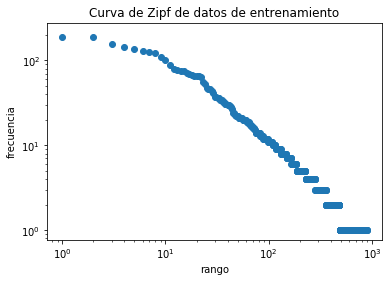

In [5]:
frec = sum([Counter(doc) for doc in train_corpus], Counter())

plt.plot(sorted(frec.values(), reverse=True), 'o')
plt.xlabel('rango')
plt.ylabel('frecuencia')
plt.xscale('log')
plt.yscale('log')
plt.title('Curva de Zipf de datos de entrenamiento')
plt.show()

Sustituyo los hapax por el identificador <unk\>

In [6]:
train_corpus_unk = [
    [
        # Si la frecuencia de la palabra es 1, se sustituye por UNK
        (UNK if frec[w] == 1 else w)
        for w in doc
    ] 
    for doc in train_corpus 
]

print('Ejemplos:')
for docs in train_corpus_unk[:5]:
        print(docs) # Muestro 5 ejemplos

Ejemplos:
['per', 'entonc', 'el', 'ultim', 'dia', 'el', 'lun', 'termin', 'la', 'fiest']
['y', 'por', 'tod', 'termin', 'com', 'veinticinc', 'vuelt']
['pues', 'com', 'se', 'enferm', 'ya', 'no', 'quer', 'com', 'tortill', 'no', 'quer', 'com', 'sal']
['y', 'cuart', 'par', 'que', 'vay', 'dos', 'segund', 'palm']
['en', 'cuant', 'vend', 'un', 'molcajet', 'com', 'esos', 'de', 'alla']


### Paso 2

Insertar símbolos de inicio y final de cadena.

In [7]:
train_corpus_unk = list(map(lambda doc: [BOS, *doc, EOS], train_corpus_unk))
for doc in train_corpus_unk[:5]:
    print(doc)

['<BOS>', 'per', 'entonc', 'el', 'ultim', 'dia', 'el', 'lun', 'termin', 'la', 'fiest', '<EOS>']
['<BOS>', 'y', 'por', 'tod', 'termin', 'com', 'veinticinc', 'vuelt', '<EOS>']
['<BOS>', 'pues', 'com', 'se', 'enferm', 'ya', 'no', 'quer', 'com', 'tortill', 'no', 'quer', 'com', 'sal', '<EOS>']
['<BOS>', 'y', 'cuart', 'par', 'que', 'vay', 'dos', 'segund', 'palm', '<EOS>']
['<BOS>', 'en', 'cuant', 'vend', 'un', 'molcajet', 'com', 'esos', 'de', 'alla', '<EOS>']


### Paso 3

Obtener los bigramas que aparecen en el texto (indexar numéricamente).

In [8]:
# Indexo numéricamente los stems
vocab = defaultdict() 
# El método default_factory sirve para asignar un nuevo valor por defecto
# en caso de no encontrar el indice dado
vocab.default_factory = lambda: len(vocab)

# Indexo numéricamente las palabras en los documentos
corpus_ids = [[vocab[w] for w in doc] for doc in train_corpus_unk]

print('Ejemplos de palabras en el vocabulario')
for palabra, i in list(vocab.items())[:10]:
    print(f'  {palabra} : {i}')

print('\nEjemplos de oraciones indexadas numéricamente')
for doc in corpus_ids[:6]:
    print(' ', doc)

Ejemplos de palabras en el vocabulario
  <BOS> : 0
  per : 1
  entonc : 2
  el : 3
  ultim : 4
  dia : 5
  lun : 6
  termin : 7
  la : 8
  fiest : 9

Ejemplos de oraciones indexadas numéricamente
  [0, 1, 2, 3, 4, 5, 3, 6, 7, 8, 9, 10]
  [0, 11, 12, 13, 7, 14, 15, 16, 10]
  [0, 17, 14, 18, 19, 20, 21, 22, 14, 23, 21, 22, 14, 24, 10]
  [0, 11, 25, 26, 27, 28, 29, 30, 31, 10]
  [0, 32, 33, 34, 35, 36, 14, 37, 38, 39, 10]
  [0, 40, 27, 41, 42, 3, 42, 10]


In [9]:
inv_vocab = { item : key for key, item in vocab.items()}

```doc[:-1]``` toma todos las cadenas de un documento (frase) excepto la última

```doc[1:]``` toma todos las cadenas de un documento (frase) excepto la primera

Con zip, uno una cadena de la primer lista con una de la segunda en tuplas (bigramas)

In [10]:
bigramas = [bi for doc in train_corpus_unk for bi in zip(doc[:-1], doc[1:])]

bigramas[:20] # Ejemplos con cadenas

[('<BOS>', 'per'),
 ('per', 'entonc'),
 ('entonc', 'el'),
 ('el', 'ultim'),
 ('ultim', 'dia'),
 ('dia', 'el'),
 ('el', 'lun'),
 ('lun', 'termin'),
 ('termin', 'la'),
 ('la', 'fiest'),
 ('fiest', '<EOS>'),
 ('<BOS>', 'y'),
 ('y', 'por'),
 ('por', 'tod'),
 ('tod', 'termin'),
 ('termin', 'com'),
 ('com', 'veinticinc'),
 ('veinticinc', 'vuelt'),
 ('vuelt', '<EOS>'),
 ('<BOS>', 'pues')]

In [11]:
bigramas_ids = [bi for doc in corpus_ids for bi in zip(doc[:-1], doc[1:])]
bigramas_ids[:20] # Ejemplos de bigramas indexados numéricamente

[(0, 1),
 (1, 2),
 (2, 3),
 (3, 4),
 (4, 5),
 (5, 3),
 (3, 6),
 (6, 7),
 (7, 8),
 (8, 9),
 (9, 10),
 (0, 11),
 (11, 12),
 (12, 13),
 (13, 7),
 (7, 14),
 (14, 15),
 (15, 16),
 (16, 10),
 (0, 17)]

### Paso 4

Entrenar con los bigramas la red neuronal y obtener los valores para los hiperparámetros. Tomar de 100 unidades para la primera capa oculta (capa lineal) y 300 para la segunda capa oculta (capa con tanh).

In [12]:
# Hiperparámetros
d = 100
m = 300
epochs = 50
lr = 0.1
# Constantes
N = len(vocab)

In [40]:
class Bengio2003:
    m = 10
    d = 2
    N = 0
    bigramas = []
    C = []
    W = []
    b = []
    U = []
    c = []
    h = []
    def __init__(self, bigramas, d, m, N):
        self.d = d
        self.m = m
        self.N = N
        self.bigramas = bigramas

    def inicializar_pesos(self):
        self.C = np.random.random((d, N))
        self.W = np.random.random((m, d))
        self.b = np.ones(m)
        self.U = np.random.random((N, m))
        self.c = np.ones(N)
    
    def forward(self, i_x):
        # La capa embedding se reduce a C_1[:, i_x]
        self.h = np.tanh(self.W.dot(self.C[:, i_x]) + self.b) # Segunda capa oculta
        a = self.U.dot(self.h) + self.c # Preactivación
        exp_a = np.exp(a - a.max()) # Exponencial de la preactivación
        return exp_a/exp_a.sum() # Capa de salida softmax

    def backprop(self, i_x, i_y, prob_salida):
        y_pred = np.argmax(prob_salida) # El índice de la palabra que predijo
        
        # Backprop
        d_out = np.array(prob_salida) #.reshape(N, 1)
        d_out[i_y] -= 1  # p(w_k | w_i) - y_k
        d_h = (1-self.h**2)*np.dot(d_out.T, self.U)
        d_c = np.dot(d_h.T, self.W)

        # Actualizamos los pesos
        # self.U -= lr*d_out.reshape(self.N, 1)*self.h.reshape(1, self.m)
        self.U -= lr*d_out.reshape(self.N, 1)*self.h.reshape(1, self.m)
        self.c -= lr*d_out
        self.W -= lr*d_h.reshape(self.m, 1)*self.C[:,i_x].reshape(1,self.d)
        self.b -= d_h
        self.C[:, i_x] -= lr*d_c # Las demás filas no nos interesan, porque son 0
        # return ((U, c), (W, b), C)

    def predecir(self, i_x):
        # La capa embedding se reduce a C_1[:, i_x]
        h = np.tanh(self.W.dot(self.C[:, i_x]) + self.b) # Segunda capa oculta
        a = self.U.dot(h) + self.c # Preactivación
        exp_a = np.exp(a - a.max()) # Exponencial de la preactivación
        prob_salida = exp_a/exp_a.sum() # Capa de salida softmax
        return np.argmax(prob_salida)
    
    def f_costo(self):
        pass
    
    def entrenar(self, epochs=5, lr=0.1):
        for epoch in range(epochs):
            np.random.shuffle(bigramas)
            cross_entropy = 0
            for bigrama in self.bigramas:
                i_x = bigrama[0] # El índice de la primer palabra del bigrama
                i_y = bigrama[1] # El índice de la segunda palabra del bigrama
                print(f'  Bigrama: {inv_vocab[i_x]} {inv_vocab[i_y]}')
                prob_salida = self.forward(i_x)
                print(f'  Predicción: {inv_vocab[i_x]} {inv_vocab[np.argmax(prob_salida)]}')
                self.backprop(i_x, i_y, prob_salida)
                cross_entropy -= prob_salida[i_y]
            print(f'Epoch: {epoch+1} \tEntropía cruzada: {cross_entropy}')
            


In [41]:
modelo = Bengio2003(bigramas_ids[:20], d, m, N)


In [44]:
modelo.inicializar_pesos()

In [45]:
modelo.entrenar(epochs = 5)

Bigrama: <BOS> per
  Predicción: <BOS> animal
  Bigrama: per entonc
  Predicción: per per
  Bigrama: entonc el
  Predicción: entonc entonc
  Bigrama: el ultim
  Predicción: el el
  Bigrama: ultim dia
  Predicción: ultim ultim
  Bigrama: dia el
  Predicción: dia dia
  Bigrama: el lun
  Predicción: el el
  Bigrama: lun termin
  Predicción: lun lun
  Bigrama: termin la
  Predicción: termin termin
  Bigrama: la fiest
  Predicción: la la
  Bigrama: fiest <EOS>
  Predicción: fiest fiest
  Bigrama: <BOS> y
  Predicción: <BOS> <EOS>
  Bigrama: y por
  Predicción: y y
  Bigrama: por tod
  Predicción: por por
  Bigrama: tod termin
  Predicción: tod tod
  Bigrama: termin com
  Predicción: termin termin
  Bigrama: com veinticinc
  Predicción: com com
  Bigrama: veinticinc vuelt
  Predicción: veinticinc veinticinc
  Bigrama: vuelt <EOS>
  Predicción: vuelt vuelt
  Bigrama: <BOS> pues
  Predicción: <BOS> <EOS>
Epoch: 1 	Entropía cruzada: -0.00016157530144939215
  Bigrama: <BOS> per
  Predicción: <BO

In [39]:
print(f'{inv_vocab[100]} {inv_vocab[modelo.predecir(100)]}')
print(f'{inv_vocab[10]} {inv_vocab[modelo.predecir(10)]}')
print(f'{inv_vocab[200]} {inv_vocab[modelo.predecir(200)]}')

vez cay
<EOS> cay
han cay


Defino la matriz de la primer capa oculta (embedding). $ C \in \mathbb{R}^{d \times N} $.

In [20]:
# inv_vocab[100]
len(bigramas_ids)

6956

In [56]:
C = np.random.random((d, N))

Defino la matriz de la segunda capa oculta. 

In [57]:
W = np.random.random((m, d))
b = np.random.random(m)

Defino la matriz de la capa de salida

In [58]:
U = np.random.random((N, m))
c = np.random.random(N)

In [113]:
bigrama = bigramas_ids[8]

i_x = bigrama[0] # El índice de la primer palabra del bigrama
y = bigrama[1] # El índice de la segunda palabra del bigrama
# La capa embedding se reduce a C_1[:, i_x]
h = np.tanh(np.dot(W, C[:, i_x]) + b) # Segunda capa oculta
a = np.dot(U, h) + c # Preactivación
exp_a = np.exp(a) # Exponencial de la preactivación
salida = exp_a/np.sum(exp_a) # Capa de salida softmax
y_pred = np.argmax(salida)

# Backprop
d_out = np.array(salida) #.reshape(N, 1)
d_out[y_pred] -= 1  # p(w_k | w_i) - y_k
d_h = (1-h**2)*np.dot( d_out.T, U)
d_c = np.dot(d_h.T, W)

# Actualizamos los pesos
U -= lr*d_out.reshape(N, 1)*h.reshape(1, m)
c -= lr*d_out
W -= lr*d_h.reshape(m, 1)*C[:,i_x].reshape(1,d)
b -= d_h
C[:, i_x] -= lr*d_c # Las demás filas no nos interesan, porque son 0



# d_out[y_pred] -= 1 # Actualizamos el indice de la palabra que vimos
# d_h = np.dot([1-h**2], np.sum(np.dot(d_out, U)))
# d_c = np.sum(np.dot(C_1, d_h))
# d_c

In [114]:
-np.log(salida[y]).sum(0)

29.8786822793441

In [54]:
print(np.dot( d_out.T, U).shape)
# print(d_out.shape)
print(U.shape)

(300,)
(513, 300)


In [87]:
# (lr*d_out.reshape(N,1)*h.reshape(1, m)).shape
# (lr*d_h.reshape(m, 1)*C[:,i_x].reshape(1,d)).shape
# C[i_x] -= (lr*d_c.reshape(d, 1)*x.reshape(1,n)).shape
d_out.shape

(513,)

In [88]:
np.dot(d_out.reshape(N,1), h.reshape(1, m)).shape
# np.dot(h.T, d_out).shape

(513, 300)

In [85]:
# W.shape
C[:,500].shape

(100,)

In [50]:

# np.dot(U[y_pred], d_out)
print(U[:5,:5])
print((d_out.reshape(N, 1) * h.reshape(1, m))[:5,:5])

[[0.8521674  0.46924574 0.67566001 0.86996629 0.70951898]
 [0.65642743 0.24748766 0.22169943 0.72332663 0.9762052 ]
 [0.51533426 0.82602171 0.8228892  0.58609216 0.37992083]
 [0.46798472 0.14846082 0.63793933 0.83925569 0.19452547]
 [0.73977964 0.07260144 0.55099518 0.30339021 0.43607307]]
[[1.46918059e-02 1.46918059e-02 1.46918059e-02 1.46918059e-02
  1.46918059e-02]
 [3.47215550e-05 3.47215550e-05 3.47215550e-05 3.47215550e-05
  3.47215550e-05]
 [1.92430802e-09 1.92430802e-09 1.92430802e-09 1.92430802e-09
  1.92430802e-09]
 [2.42959879e-06 2.42959879e-06 2.42959879e-06 2.42959879e-06
  2.42959879e-06]
 [1.39447895e-06 1.39447895e-06 1.39447895e-06 1.39447895e-06
  1.39447895e-06]]


In [40]:
np.random.shuffle(bigramas_ids)
for i in range(iterac):
    for bigrama in bigramas_ids:
        # Forward
        i_x = bigrama[0] # El índice de la primer palabra del bigrama
        y = bigrama[1] # El índice de la segunda palabra del bigrama
        # La capa embedding se reduce a C_1[:, i_x]
        h = np.tanh(np.dot(C_2, C_1[:, i_x]) + b_2) # Segunda capa oculta
        a = np.dot(U, h) + c # Preactivación
        exp_a = np.exp(a) # Exponencial de la preactivación
        salida = exp_a/np.sum(exp_a) # Capa de salida softmax
        d_out
        # Backprop


NameError: name 'iterac' is not defined

In [75]:
d_out = np.array(salida).reshape(N, 1)
d_out[0] -= dout[]

array([7.30732953e-08])

In [39]:
-np.sum(np.sum(np.dot(np.log(salida))))

500

In [80]:
y_pred

372

In [83]:
inv_vocab = { item : key for key, item in vocab.items()}

In [85]:
inv_vocab[96]

'muj'